<b>Dans ce notebook on ressort des éléments permettant de prendre connaissance du dataset et d'en déduire les actions de clean a effectuer</b>
<p><a href="https://app.mindmup.com/map/_free/2021/01/175c91405bdb11eb9f33cf002549c867">mind map du projet</a></p>

# Table of contents
1. [Projet](#project)
2. [Load du dataset](#load)
3. [Examen de forme](#exam)
4. [Définition des mots clés](#keys)

   4.1 [Catégories de produit](#categ)
   
   4.2 [Groupes de produit](#groups)
5. [Analyse quantitative des features](#qanalyse)

   5.1 [Représentativité des features](#skewed_features)
   
   5.2 [Densité de remplissage des features](#features_density)

   5.3 [Full NaN features](#full_nan)
   
   5.4 [Zero NaN features](#zero_nan)
   
   5.5 [Partial NaN features](#partial_nan)
   
6. [Sélection des aggrégats porteurs d'information](#aggregates_selection)

   6.1 [Groupes de nutriments](#nutriments_groups)

   6.2 [Features au libellé similaire](#similarities)

7. [Exploration des entrants qualitatifs du dataset](#exploring)

   7.1 [Qui sont les créateurs d'information](#creators)
   
   7.2 [Quels pays sont représentés](#countries)
   
   7.3 [Quelles marques sont représentées](#brands)
   
   7.4 [Quels supermachés sont représentés](#stores)
   
   7.5 [Quelles catégories sont représentées](#categories)
   
   7.6 [Conclusion](#conclusion)
8. [Analyse qualitative](#quality)

   8.1 [Détection des outliers](#outliers)
   
   8.2 [Définition des données à compléter](#complete)
   
   8.3 [Identification des doublons](#duplicates)
9. [Définition des features de scoring](#def_features)
10. [Proposition d'application](#application)

<b style="background-color:tomato;font-size:14px;">1. PROJET<b>
   <a id="project"></a>  

<p>Les objectifs affichés du Ministère de Santé Publique en matière de pratiques alimentaires sont clairement définis dans la rubrique Recommandations de son site lié à la nutrition : <a href="https://www.mangerbouger.fr/">site mangerbouger</a></p>
<p>Ces recommandations ciblent des catégories d'aliments pour lesquelles le Ministère définit une tendance à les intégrer dans les repas (Augmenter, Aller vers, Réduire)</p>

<p>De façon à quantifier l'impact de ces recommandations il est important de s'appuyer sur des indicateurs clairement établis. On distingue 2 indicateurs :</p>
<p>- le score nutritionnel : il permet, sur la base de la composition du produit (aliment brut ou bien produit transformé) en différents nutriments et ingrédients majeurs pour la santé, de donner une valeur unique d’estimation de la qualité nutritionnelle de l’aliment, sur une échelle ordinale continue allant de -15
(meilleure qualité nutritionnelle) à +40 (pire qualité nutritionnelle) </p>
<p>- le nutriscore : il définit une échelle graphique qui scinde le score nutritionnel en 5 classes (exprimées par une couleur associée à une lettre) et vise à faciliter la visibilité, la lisibilité, et la compréhension de la qualité nutritionnelle par le consommateur</p>

<p>voir références:</p>
<p>&nbsp;&nbsp;&nbsp;-&nbsp;<a href="https://fr.wikipedia.org/wiki/Nutri-score#M%C3%A9thode_de_calcul_du_score">Définition Wikipedia</a></p>
<p>&nbsp;&nbsp;&nbsp;-&nbsp;<a href="https://www.santepubliquefrance.fr/content/download/150262/file/QR%20scientifique%20et%20technique_271020.pdf">Définition Ministère santé publique</a></p>
<p>Lors de la découverte du dataset nous serons particulièrement attachés à mettre en valeur les features porteuses des informations relatives aux postes entrant dans la définition du score nutritionnel tel qu'il est défini par le Ministère :</p>
<p>
<table>
    <tr>
        <td align="center" bgcolor="green">Feature</td>
        <td align="center" bgcolor="green">Impact</td>
    </tr>
    <tr>
        <td>Apport calorique</td>
        <td>Négatif</td>
    </tr>
    <tr>
        <td>Sucre</td>
        <td>Négatif</td>
    </tr>
    <tr>
        <td>Graisses saturées</td>
        <td>Négatif</td>
    </tr>
    <tr>
        <td>Sel</td>
        <td>Négatif</td>
    </tr>
    <tr>
        <td>Fruits, légumes, légumineuses, fruits à coque et huiles de colza, de noix et d’olive</td>
        <td>Positif</td>
    </tr>
    <tr>
        <td>Protéines</td>
        <td>Positif</td>
    </tr>
    <tr>
        <td>Fibres</td>
        <td>Positif</td>
    </tr>
</table>
</p>

<b style="background-color:tomato;font-size:14px;">2. LOAD DATASET<b>
   <a id="load"></a>  

In [127]:
import numpy as np 
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
import re
import collections

#On ne prend qu'un échantillon du fait des limitations mémoire de la machine
data=pd.read_csv('../dataset/en.openfoodfacts.org.products.csv',sep='\t',nrows=300000, low_memory=False)
#data=pd.read_csv('../dataset/dataset_chunk_5.csv',sep='\t',nrows=300000, low_memory=False)
#data=pd.read_csv('../dataset/consolidated-167273.csv',sep='\t',nrows=300000, low_memory=False)
#data=pd.read_csv('../dataset/consolidated-268220.csv',sep='\t',nrows=300000, low_memory=False)



<b style="background-color:tomato;font-size:14px;">3. EXAMEN DE FORME<b>
   <a id="exam"></a>  

In [128]:
shape = data.shape
rows = shape[0]
print(shape)

(300000, 183)


In [129]:
dataTypeSeries = data.dtypes
dataTypeSeries

code                   object
url                    object
creator                object
created_t               int64
created_datetime       object
                       ...   
choline_100g          float64
phylloquinone_100g    float64
beta-glucan_100g      float64
inositol_100g         float64
carnitine_100g        float64
Length: 183, dtype: object

In [130]:
rows = data.shape
rows = rows[0]
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,100g,...,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b  style="background-color:tomato;font-size:14px;">4. DEFINITION DES MOTS CLE<b>
    <a id="keys"></a> 

<p>Le dataset permet de catégoriser 4 grandes familles de features pour décrire un produit (ref: <a href="https://world.openfoodfacts.org/data/data-fields.txt"> descrption dataset</a>) :</p> 
<table>
    <tr>
       <td align="center" bgcolor="red">Description</td>
        <td align="center" bgcolor="red">Type de variable</td>
        <td align="center" bgcolor="red">Exemple</td>
    </tr>    
    <tr>
        <td>Features de référencement produit</td>
        <td>Qualitative</td>
        <td>product_name: nom du produit</td>
    </tr>
    <tr>
        <td>Features de caractérisation du produit sous forme d'informations structurées</td>
        <td>Qualitative</td>
        <td>categories_tags: catégories du produit</td>
    </tr>
    <tr>
        <td>Features de composition du produit (ingrédients, additifs)</td>
        <td>Qualitative</td>
        <td>additives: liste des additifs présents dans le produit</td>
    </tr>
    <tr>
        <td>Features de détail nutritionnel du produit</td>
        <td>Quantitative</td>
        <td>vitamin-d_100g: grammage de vitamine d pour 100g de produit</td>
    </tr>

</table>    


<b style="background-color:tomato;font-size:14px;">4.1 Catégories<b>
    <a id="categ"></a> 

On s'intéresse ici à la feature 'categories'. A priori du fait de son nom cette feature doit permettre de dégager des groupes de rattachement entre produits. On vérifie son contenu. 

In [131]:
def count_words(df, colonne = 'categories'):
    list_words = set()
    for word in df[colonne].str.split(','):
        if isinstance(word, float): continue
        list_words = set().union(word, list_words)       
    print("Nb de catégories dans '{}': {}".format(colonne, len(list_words)))
    return list(list_words)
category_keys = count_words(data, 'categories')

Nb de catégories dans 'categories': 8799


Illustrons par un nuage de mots (wordcloud) les catégories qui ressortent

In [132]:
count_keyword = dict()
for index, col in data['categories'].iteritems():
    if isinstance(col, float): continue
    for s in col.split(','):
        if s in count_keyword.keys():
            count_keyword[s] += 1
        else:
            count_keyword[s] = 1

keyword_census = []
for k,v in count_keyword.items():
    keyword_census.append([k,v])
keyword_census.sort(key = lambda x:x[1], reverse = True)

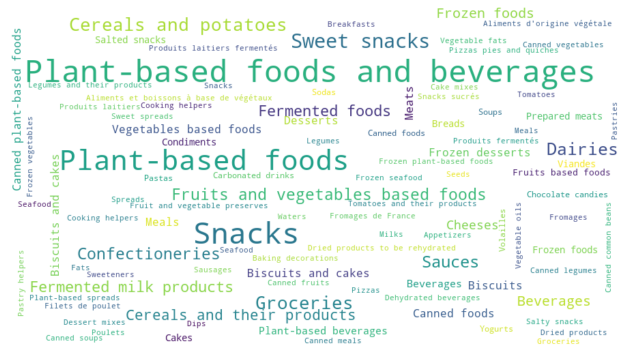

In [133]:
fig = plt.figure(1, figsize=(11,9))
ax1 = fig.add_subplot(1,1,1)
words = dict()
trunc_occurences = keyword_census[0:100]
for s in trunc_occurences:
    words[s[0]] = s[1]

wordcloud = WordCloud(width=900,height=500, background_color='white', 
                      max_words=1628,relative_scaling=0.6,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
plt.show()

Cette mise en perpective nous permet de comprendre que les produits sont catégorisés en fonction de critères qui renseignent à la fois sur la famille de produit, sur l'ingrédient principal qui le compose, sur la méthode de fabrication du produit, .... D'autre part elle est renseignée en plusieurs langues, ce qui fait que cette information est assez générique et peu homogène.

<b style="background-color:tomato;font-size:12px;">4.2 Groupes de produits<b>
    <a id="groups"></a> 

<p>Nous avons vu que la notion de catégorie était plutôt générale. Pour mener des analyses pertinentes il apparait nécessaire d'identifier des features permettant de cerner au plus juste la famille de produit. </p>
<p>Une revue des features qualitatives nous a permis de constater que deux features sont candidates: pnns_groups_1 et pnns_groups_2</p>

In [134]:
pnns_group1_keys = count_words(data, 'pnns_groups_1')  
pnns_group2_keys = count_words(data, 'pnns_groups_2')

Nb de catégories dans 'pnns_groups_1': 13
Nb de catégories dans 'pnns_groups_2': 44


In [135]:
pnns_group1_keys

['fruits-and-vegetables',
 'Salty snacks',
 'unknown',
 'Milk and dairy products',
 'Beverages',
 'Fat and sauces',
 'Composite foods',
 'Fruits and vegetables',
 'Fish Meat Eggs',
 'cereals-and-potatoes',
 'Sugary snacks',
 'sugary-snacks',
 'Cereals and potatoes']

In [136]:
pnns_group2_keys

['Legumes',
 'Sandwiches',
 'Vegetables',
 'vegetables',
 'Chocolate products',
 'Dried fruits',
 'Pizza pies and quiche',
 'Eggs',
 'Artificially sweetened beverages',
 'Dairy desserts',
 'Sweets',
 'One-dish meals',
 'Fats',
 'unknown',
 'Unsweetened beverages',
 'cereals',
 'Cheese',
 'Alcoholic beverages',
 'Fruit nectars',
 'Fruits',
 'Waters and flavored waters',
 'Dressings and sauces',
 'Appetizers',
 'Teas and herbal teas and coffees',
 'Salty and fatty products',
 'Bread',
 'Soups',
 'Fruit juices',
 'Ice cream',
 'Biscuits and cakes',
 'Plant-based milk substitutes',
 'Fish and seafood',
 'Offals',
 'pastries',
 'Pizza pies and quiches',
 'Cereals',
 'Milk and yogurt',
 'Breakfast cereals',
 'Sweetened beverages',
 'Nuts',
 'Processed meat',
 'Meat',
 'Potatoes',
 'fruits']

Ces catégories sont plus orientées sur la définition de l'utilisation du produit dans le cadre d'un repas. D'autre part elles sont invariantes avec la langue.

<p>Le groupe 2 de PNNS est un détail en sous-groupes du groupe 1 de PNNS. Il apparait plus pertinent de se référer à cette définition de catégorie du produit pour le définir plus précisément.</p>
<p>On constate par ailleurs qu'il y a des regroupements possibles car les libellés sont similaires (anglais vs français, ou bien à une lettre près il s'agit de la même catégorie). On définit une nouvelle feature PNNS_3 qui va effectuer ces regroupements quand ils sont possibles et conserver la définition originale pour les lignes uniques :</p>
<table>
    <tr>
       <td align="center" bgcolor="blue">Libellé de Regroupement</td>
        <td align="center" bgcolor="blue">Catégories regroupées</td>
    </tr>    
    <tr>
        <td>Fruit juices</td>
        <td>Fruit juices,Fruit nectars</td>
    </tr>
    <tr>
        <td>Vegetables</td>
        <td>Legumes,vegetables,Vegetables</td>
    </tr>
    <tr>
        <td>Fruits</td>
        <td>fruits,Fruits</td>
    </tr>
    <tr>
        <td>Sweetened beverages</td>
        <td>Artificially sweetened beverages,Sweetened beverages</td>
    </tr>
    <tr>
        <td>Pizza pies and quiches</td>
        <td>Pizza pies and quiche,Pizza pies and quiches</td>
    </tr>
    <tr>
        <td>Cereals</td>
        <td>cereals,Cereals</td>
    </tr>
    <tr>
        <td>Nuts</td>
        <td>Nuts</td>
    </tr>
    <tr>
        <td>Ice cream</td>
        <td>Ice cream</td>
    </tr>
    <tr>
        <td>Fish and seafood</td>
        <td>Fish and seafood</td>
    </tr>
    <tr>
        <td>Unsweetened beverages</td>
        <td>Unsweetened beverages</td>
    </tr>
    <tr>
        <td>Sweets</td>
        <td>Sweets</td>
    </tr>
    <tr>
        <td>Cheese</td>
        <td>Cheese</td>
    </tr>
    <tr>
        <td>Processed meat</td>
        <td>Processed meat</td>
    </tr>
    <tr>
        <td>Waters and flavored waters</td>
        <td>Waters and flavored waters</td>
    </tr>
    <tr>
        <td>Soups</td>
        <td>Soups</td>
    </tr>
    <tr>
        <td>Dairy desserts</td>
        <td>Dairy desserts</td>
    </tr>
    <tr>
        <td>unknown</td>
        <td>unknown</td>
    </tr>
    <tr>
        <td>Biscuits and cakes</td>
        <td>Biscuits and cakes</td>
    </tr>
    <tr>
        <td>Meat</td>
        <td>Meat</td>
    </tr>
    <tr>
        <td>Bread</td>
        <td>Bread</td>
    </tr>
    <tr>
        <td>Sandwiches</td>
        <td>Sandwiches</td>
    </tr>
    <tr>
        <td>One-dish meals</td>
        <td>One-dish meals</td>
    </tr>
    <tr>
        <td>Fats</td>
        <td>Fats</td>
    </tr>
    <tr>
        <td>Chocolate products</td>
        <td>Chocolate products</td>
    </tr>
    <tr>
        <td>Plant-based milk substitutes</td>
        <td>Plant-based milk substitutes</td>
    </tr>
    <tr>
        <td>Milk and yogurt</td>
        <td>Milk and yogurt</td>
    </tr>
    <tr>
        <td>Dressings and sauces</td>
        <td>Dressings and sauces</td>
    </tr>
    <tr>
        <td>Appetizers</td>
        <td>Appetizers</td>
    </tr>
    <tr>
        <td>Potatoes</td>
        <td>Potatoes</td>
    </tr>
    <tr>
        <td>Alcoholic beverages</td>
        <td>Alcoholic beverages</td>
    </tr>
    <tr>
        <td>Dried fruits</td>
        <td>Dried fruits</td>
    </tr>
    <tr>
        <td>Eggs</td>
        <td>Eggs</td>
    </tr>
    <tr>
        <td>pastries</td>
        <td>pastries</td>
    </tr>
    <tr>
        <td>Teas and herbal teas and coffees</td>
        <td>Teas and herbal teas and coffees</td>
    </tr>
    <tr>
        <td>Breakfast cereals</td>
        <td>Breakfast cereals</td>
    </tr>
    <tr>
        <td>Offals</td>
        <td>Offals</td>
    </tr>
    <tr>
        <td>Salty and fatty products</td>
        <td>Salty and fatty products</td>
    </tr>
</table>

<b style="background-color:tomato;font-size:14px;">5. ANALYSE QUANTITATIVE DES FEATURES</b>
<a id="qanalyse"></a> 

<b style="background-color:tomato;font-size:12px;">5.1 Représentativité des features</b>
<a id="skewed_features"></a> 

<AxesSubplot:title={'center':'Représentativité des features dans le dataset (seuil = 5%)'}>

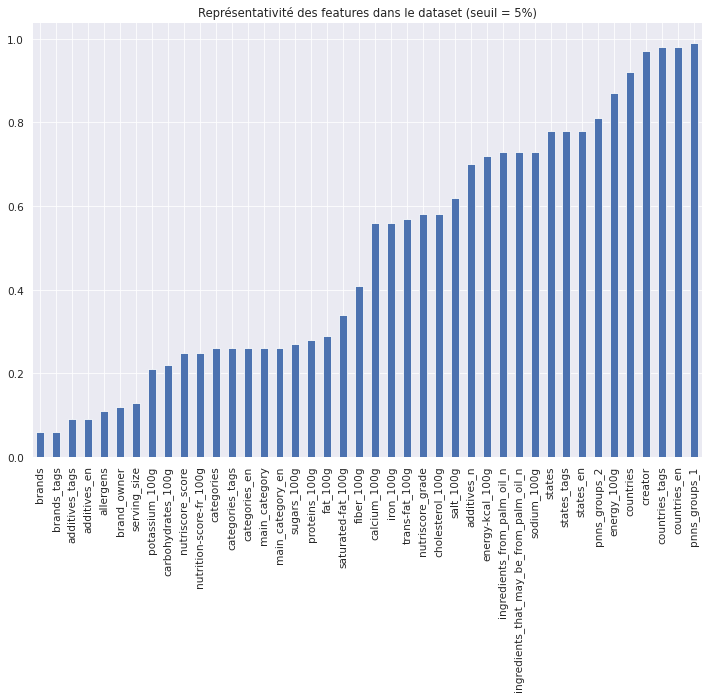

In [137]:
columns = data.columns
over_skewed={}

for c in columns:
    try:
        counts = data[c].value_counts()
        counts = counts.to_frame(name='nb')
        counts['pourcentage'] = counts['nb']/rows
        pct = round(sum(counts[0:10]['pourcentage']),2)
        if pct > 0.05:
            over_skewed[c] = pct
    except:
        i=1
t = dict(sorted(over_skewed.items(), key=lambda item: item[1]))
unusual_df = pd.DataFrame.from_dict(t, orient='index')
unusual_df.plot(kind='bar', figsize=(12,8), title="Représentativité des features dans le dataset (seuil = 5%)", legend=False)

<p>Proportionnellement les features de catégorisation du produit ressortent parmis celles qui sont les mieux renseignées, les produits sont donc plutôt bien décrits du point de vue catégoriel.<p> A contrario les composants d'analyse nutritionnelle fine qui donne le détail de la composition du produit ne sont pas très bien représentés. <p>On pourrait conclure sur le fait que le dataset porte des informations générales sur les produits mais que le niveau de détail fin n'est pas très bon. 

<b style="background-color:tomato;font-size:12px;">5.2 Densité de remplissage des features</b>
<a id="features_density"></a> 

On cherche à comprendre comment est rempli le dataset.

In [138]:
percent_of_nans = data.isnull().sum().sort_values(ascending=False) / data.shape[0] * 100

Text(0.5, 1.0, 'Dispersion de nans dans les features')

<Figure size 720x360 with 0 Axes>

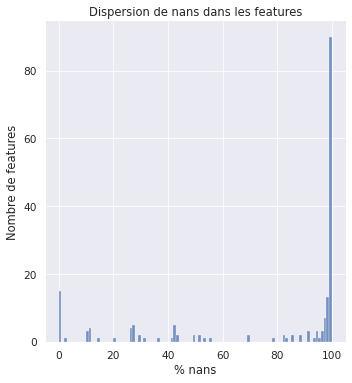

In [139]:
plt.figure(figsize=(10,5))
sns.displot(percent_of_nans, bins=100, kde=False)
plt.xlabel("% nans")
plt.ylabel("Nombre de features")
plt.title("Dispersion de nans dans les features")

<p>La mise en perspective du nombre de NaN par feature nous montre :</p> 
<p>&nbsp;&nbsp;&nbsp;&nbsp;(1) que 110/183 = 60% des features ne comportent aucune information</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;(2) que 32% de features sont partiellement valorisées avec un taux de remplissage variable allant de 5% à 99%</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;(3) que seuls 15/183 = 8% de features sont renseignées à 100%</p>
<p>
<p>Pour les features du groupe (1) : ces features ne semblent pas pouvoir apporter de sens aux analyses </p>
<p>Pour les features du groupe (2) : il sera intéressant d'appliquer une méthode pour tenter de valoriser les NaN en fonction du niveau d'imputation à effectuer </p>

<b style="background-color:tomato;font-size:12px;">5.3 Full NaN features</b>
<a id="full_nan"></a> 

In [140]:
useless_features = percent_of_nans[percent_of_nans == 100].index
print('Nombre de features systématiquement non définies: ' + str(len(useless_features)))
useless_features

Nombre de features systématiquement non définies: 37


Index(['carnitine_100g', '-montanic-acid_100g', '-maltodextrins_100g',
       '-maltose_100g', '-fructose_100g', '-glucose_100g',
       '-nervonic-acid_100g', '-erucic-acid_100g', '-mead-acid_100g',
       '-gondoic-acid_100g', '-elaidic-acid_100g', '-oleic-acid_100g',
       'omega-9-fat_100g', '-dihomo-gamma-linolenic-acid_100g',
       '-gamma-linolenic-acid_100g', '-lignoceric-acid_100g',
       'beta-carotene_100g', '-stearic-acid_100g', '-palmitic-acid_100g',
       '-myristic-acid_100g', '-lauric-acid_100g', '-capric-acid_100g',
       '-caprylic-acid_100g', '-caproic-acid_100g',
       'ingredients_that_may_be_from_palm_oil', 'ingredients_from_palm_oil',
       'additives', 'no_nutriments', 'allergens_en', 'cities', 'casein_100g',
       '-melissic-acid_100g', 'nutrition-score-uk_100g', 'water-hardness_100g',
       'chlorophyl_100g', 'beta-glucan_100g', 'glycemic-index_100g'],
      dtype='object')

<b style="background-color:tomato;font-size:12px;">5.4 Zero NaN features</b>
<a id="zero_nan"></a> 
<p>Combien de features sont toujours valorisées et quelles sont-elles ?</p>

In [141]:
zero_nan_features = percent_of_nans[percent_of_nans == 0].index

print('Nombre de features systématiquement définies: ' + str(len(zero_nan_features)))
zero_nan_features

Nombre de features systématiquement définies: 10


Index(['states_en', 'states_tags', 'states', 'last_modified_datetime',
       'last_modified_t', 'created_datetime', 'created_t', 'creator', 'url',
       'code'],
      dtype='object')

Ces features sont des informations générales qui font probablement partie des champs obligatoires du formulaire de saisie du produit. 

<b style="background-color:tomato;font-size:12px;">5.5 Partiel NaN features</b>
<a id="partial_nan"></a> 
<p>On propose une analyse par quartile pour dégager 3 groupes de features :</p>
<table>
    <tr>
       <td align="center" bgcolor="red">Groupe</td>
        <td align="center" bgcolor="red">Catégorie</td>
        <td align="center" bgcolor="red">What to do</td>
    </tr>    
    <tr>
        <td>0% - 20%</td>
        <td>Features à densité élevée</td>
        <td>Features peu biaisée et donc fiables pour une exploitation dans le cadre d'une application. Pour ces features il serait intéressant de valoriser les NaN par application de la moyenne</td>
    </tr>
    <tr>
        <td>20% - 50%</td>
        <td>Features à densité moyenne</td>
        <td>Features moyennement valorisées, qu'il faudrait soit valoriser pour qu'elles soient pertinentes dans le cadre d'une application (appliquer peut être alors un algorithme knn ?), soit éviter de faire reposer l'analyse dessus.</td>
    </tr>
    <tr>
        <td>50% - 100%</td>
        <td>Features à densité faible</td>
        <td>Ces features sont trop peu valorisées, il ne semble pas judicieux de les utiliser comme fondement pour mener une analyse</td>
    </tr>
    
</table>


In [142]:
low_nans = percent_of_nans[percent_of_nans <= 20]
middle_nans = percent_of_nans[(percent_of_nans > 20) & (percent_of_nans <= 50)]
high_nans = percent_of_nans[(percent_of_nans > 50) & (percent_of_nans < 100)]
print('tranche 0-20%: ' + str(len(low_nans)))
print('tranche 20-50%: ' + str(len(middle_nans)))
print('tranche 50-100%: ' + str(len(high_nans)))


tranche 0-20%: 24
tranche 20-50%: 24
tranche 50-100%: 98


<b>0% - 20% NaN</b>

In [143]:
def rotate_labels(axes):
    for item in axes.get_xticklabels():
        item.set_rotation(60)

Text(0, 0.5, '% de NaN ')

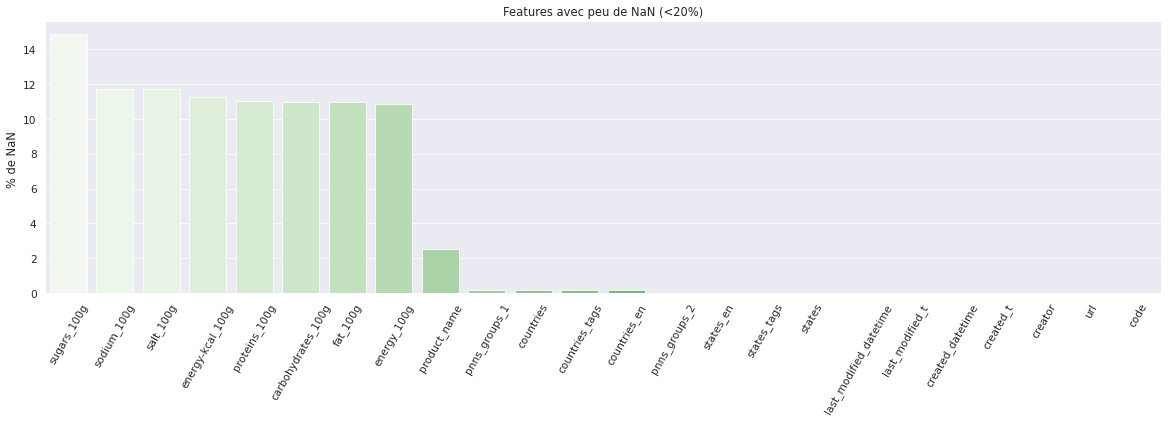

In [144]:
plt.figure(figsize=(20,5))
lows = sns.barplot(x=low_nans.index.values, y=low_nans.values, palette="Greens")
rotate_labels(lows)
plt.title("Features avec peu de NaN (<20%)")
plt.ylabel("% de NaN ")

<b>20% - 50% NaN</b>

Text(0, 0.5, '% de NaN ')

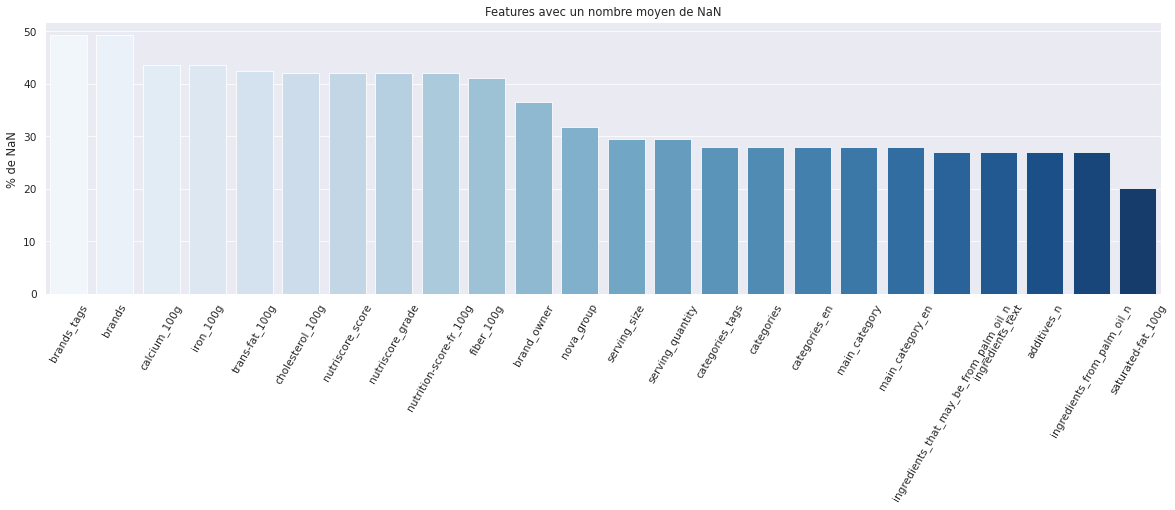

In [145]:
plt.figure(figsize=(20,5))
middle = sns.barplot(x=middle_nans.index.values, y=middle_nans.values, palette="Blues")
rotate_labels(middle)
plt.title("Features avec un nombre moyen de NaN")
plt.ylabel("% de NaN ")

<b>50% - 100% NaN</b>

Text(0, 0.5, '% de NaN ')

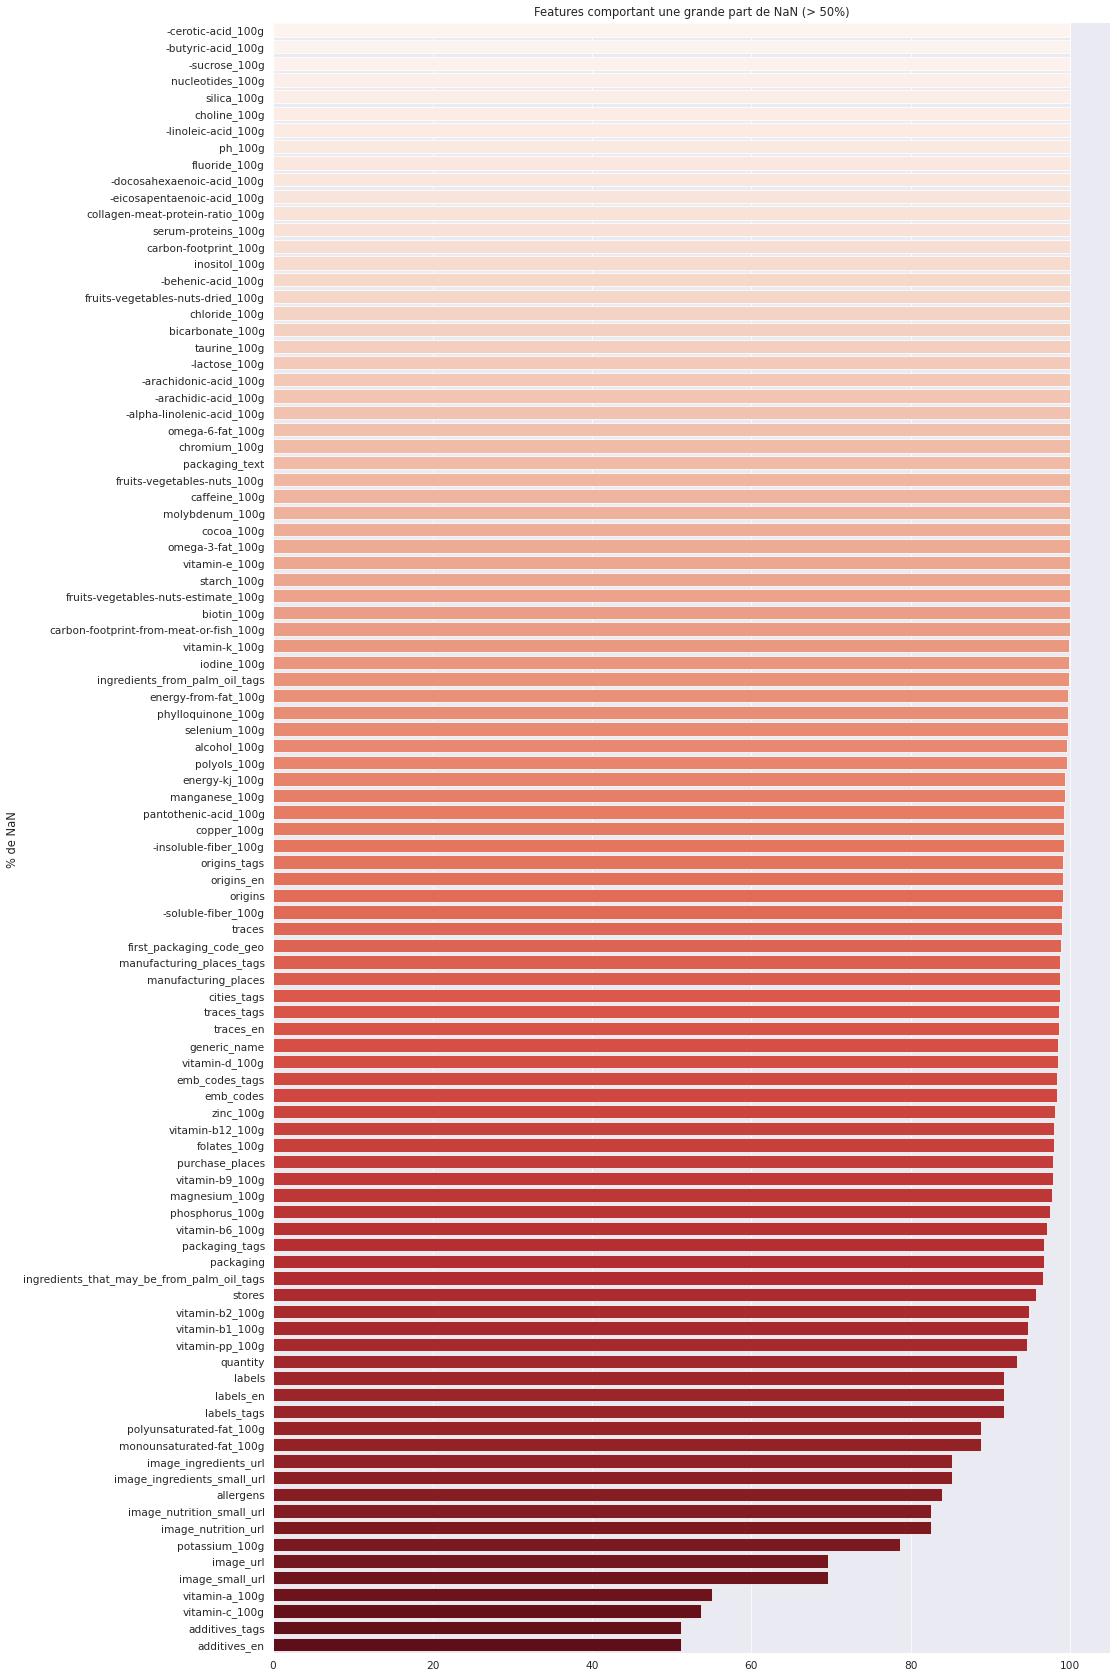

In [146]:
plt.figure(figsize=(15,30))
high = sns.barplot(y=high_nans.index.values, x=high_nans.values, palette="Reds")
plt.title("Features comportant une grande part de NaN (> 50%)")
plt.ylabel("% de NaN ")

<p>A première vue la grande partie des features entrant dans ce cas sont les détails fins d'analyse nutritionnelle (vitamines, oligo-éléments, ...). Cela peut se comprendre si l'utilisateur qui a effectué l'enregistrement soit n'en a pas connaissance car cela n'est pas répertorié sur l'étiquette du produit, soit parce que l'étape de saisie est trop fastidieuse. </p> 
</p>On constate pour ce groupe que le % de NaN varie entre 62% et 100%.<p>

<b style="background-color:tomato;font-size:14px;">6. SELECTION DES AGGREGATS PORTEURS D'INFORMATIONS</b>
<a id="aggregates_selection"></a> 

<b style="background-color:tomato;font-size:12px;">6.1 Groupes de nutriments</b>
<a id="nutriments_groups"></a> 

<p>L'objectif dans un premier temps est d'identifier les correlations positives très fortes qui indiqueraient les features porteuses d'information similaires et dont on pourrait alors ne retenir que le représentant significatif.</p><p> 
Pour cela on se sert de la matrice de correlation du coefficient de relation linéaire de Pearson.</p><p>

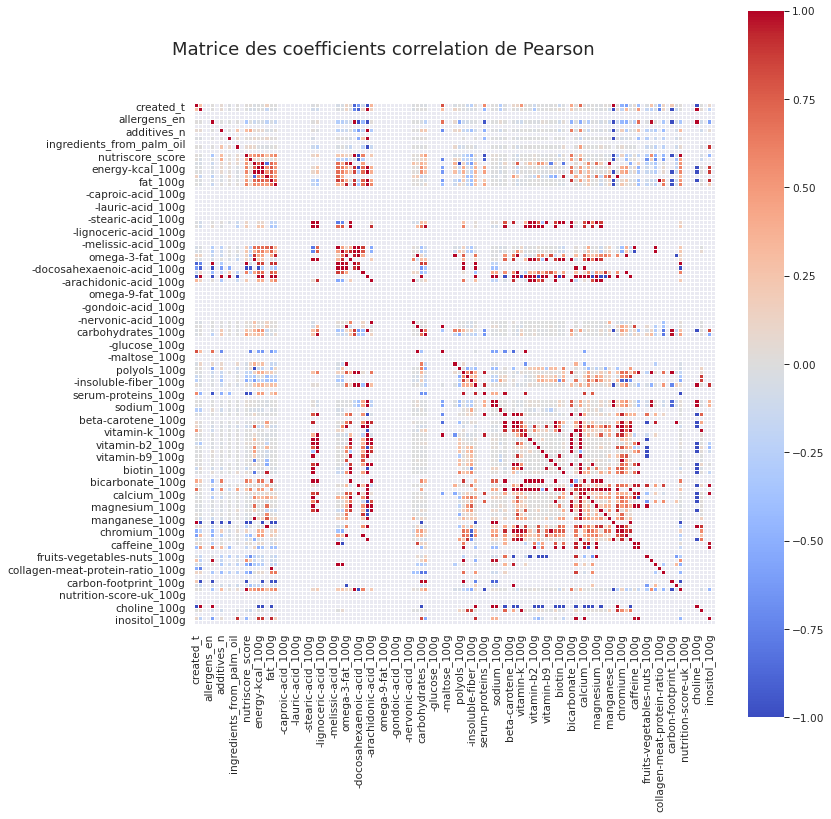

In [147]:
sns.set(context="paper", font_scale = 1.2)
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 12))
f.text(0.45, 0.93, "Matrice des coefficients correlation de Pearson", ha='center', fontsize = 18)
sns.heatmap(corrmat, square=True, linewidths=0.01, cmap="coolwarm")
plt.tight_layout()

<p>La matrice fait ressortir de nombreuses correlations positives fortes entre des variables représentant des familles de nutriments et de sous composants de ces familles.<p> Par exemple: <p>
omega-9-fat_100g et {-gondoic-acid_100g, -nervonic-acid_100g}, sachant que ces acides sont des acides gras de la famille des oméga9.  
<p>carbohydrates_100g et {-glucose_100g, -maltose_100g}, sachant que le glucose et le maltose sont des déclinaisons de glucides 
<p>Dans la perspective d'une application de santé publique le niveau de détail fin des sous composants peut être écarté.    

In [148]:
import re
print('Features détails qui ne seront pas prises en compte:')
for s in data.columns:
    if re.match('^-',s):
        print(s)

Features détails qui ne seront pas prises en compte:
-butyric-acid_100g
-caproic-acid_100g
-caprylic-acid_100g
-capric-acid_100g
-lauric-acid_100g
-myristic-acid_100g
-palmitic-acid_100g
-stearic-acid_100g
-arachidic-acid_100g
-behenic-acid_100g
-lignoceric-acid_100g
-cerotic-acid_100g
-montanic-acid_100g
-melissic-acid_100g
-alpha-linolenic-acid_100g
-eicosapentaenoic-acid_100g
-docosahexaenoic-acid_100g
-linoleic-acid_100g
-arachidonic-acid_100g
-gamma-linolenic-acid_100g
-dihomo-gamma-linolenic-acid_100g
-oleic-acid_100g
-elaidic-acid_100g
-gondoic-acid_100g
-mead-acid_100g
-erucic-acid_100g
-nervonic-acid_100g
-sucrose_100g
-glucose_100g
-fructose_100g
-lactose_100g
-maltose_100g
-maltodextrins_100g
-soluble-fiber_100g
-insoluble-fiber_100g


<b style="background-color:tomato;font-size:12px;">6.2 Features au libellé similaire</b>
<a id="similarities"></a> 

On constate qu'il y a des features dont le nom est décliné en _tags et _en<p>
Ex: categories, categories_tags, categories_en

In [149]:
list_columns = ['categories', 'categories_tags', 'categories_en']
data[data[list_columns].notnull().any(axis=1)][['product_name']+ list_columns][:20:3]

,product_name,categories,categories_tags,categories_en
3,moutarde au moût de raisin,"Epicerie, Condiments, Sauces, Moutardes","en:groceries,en:condiments,en:sauces,en:mustards","Groceries,Condiments,Sauces,Mustards"
13,Salade de carottes râpées,"Plats préparés, Légumes préparés, Carottes râp...","en:meals,en:prepared-vegetables,en:grated-carr...","Meals,Prepared vegetables,Grated carrots,Seaso..."
33,Aiguillettes de poulet,"Viandes, Volailles, Poulets, Aiguillettes de p...","en:meats,en:poultries,en:chickens,fr:aiguillet...","Meats,Poultries,Chickens,fr:Aiguillettes de po..."
60,Abondance,"Produits laitiers, Produits fermentés, Produit...","en:dairies,en:fermented-foods,en:fermented-mil...","Dairies,Fermented foods,Fermented milk product..."
66,BAguette bressan,"Aliments et boissons à base de végétaux, Alime...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo..."
72,Le rogallais chèvre brebis,en:cheeses,"en:dairies,en:fermented-foods,en:fermented-mil...","Dairies,Fermented foods,Fermented milk product..."
85,Miel de printemps,"Miels, Miels de Printemps","en:spreads,en:breakfasts,en:bee-products,en:fa...","Spreads,Breakfasts,Bee products,Farming produc..."


<b style="background-color:yellow;font-size:14px;color:black;">
################ Démontrer que les infos sont similaires en mettant en valeur que le contenu d'une feature se retrouve dans d'autres features identifiées comme redondantes (graphs) ???</b>

<p>Dans la phase de cleaning on ne conservera que les features '_tags' pour permettre une exploitation des informations (notamment l'association langue:terme)</p>

<b style="background-color:tomato;font-size:14px;">7. EXPLORATION DES ENTRANTS QUALITATIFS DU DATASET</b>
<a id="exploring"></a> 

<p>On cherche à construire une vision du contenu du dataset au travers de quelques analyses univariées (créateur, institutions, pays, etc ...)</p>

<b style="background-color:tomato;font-size:12px;">7.1 Qui sont les créateurs d'information</b>
<a id="creators"></a> 

In [150]:
def top_n(col,col_alias,n):
    counts = data[col].value_counts()
    counts = counts.to_frame(name='nombre')
    counts['pourcentage'] = (counts['nombre']/rows)*100

    top_n = round(sum(counts[0:n]['pourcentage']),2)*100
    print("Le top " + str(n) + " des", col_alias,"cumule", str(top_n/100),"% du périmètre : \n")

    # Pie chart
    sub_df=counts.head(n)
    labels = sub_df.iloc[ : , 0 ]
    labels=labels.index
    sizes = sub_df.iloc[ : , 1 ]
    explode = tuple()
    for i in range(n):
        explode += (0.1, )

    # Creating color parameters 
    colors = ( "orange", "cyan", "brown", 
              "grey", "indigo", "beige") 

    # Wedge properties 
    wp = { 'linewidth' : 1, 'edgecolor' : "green" } 

    # Creating autocpt arguments 
    def func(pct, allvalues): 
        absolute = int(pct / 100.*np.sum(allvalues)) 
        return "{:.1f}%".format(pct, absolute) 

    # Creating plot 
    fig, ax = plt.subplots(figsize =(10, 7)) 
    wedges, texts, autotexts = ax.pie(sizes,  
                                      autopct = lambda pct: func(pct, sizes), 
                                      explode = explode,  
                                      labels = labels, 
                                      shadow = True, 
                                      colors = colors, 
                                      startangle = 90, 
                                      wedgeprops = wp, 
                                      textprops = dict(color ="magenta")) 

    # Legend 
    ax.legend(wedges, labels, 
              title ="Contributeurs", 
              loc ="center left", 
              bbox_to_anchor =(1, 0, 0.5, 1)) 

    plt.setp(autotexts, size = 8, weight ="bold") 

    plt.show()     

Le top 5 des créateurs cumule 95.01 % du périmètre : 



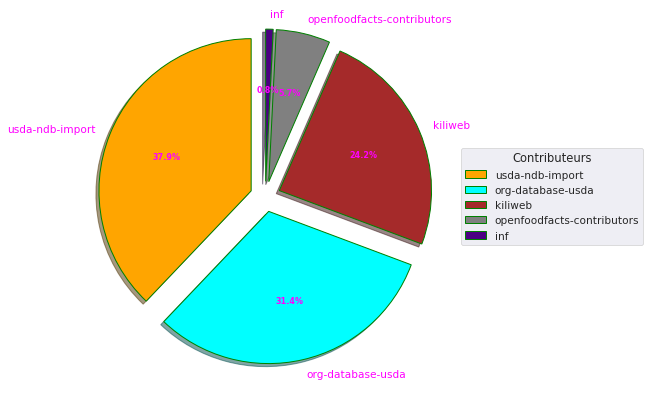

In [151]:
top_n('creator','créateurs',5)

<b style="background-color:tomato;font-size:12px;">7.2 Quels sont les pays représentés</b>
<a id="countries"></a> 

Le top 5 des pays cumule 84.92 % du périmètre : 



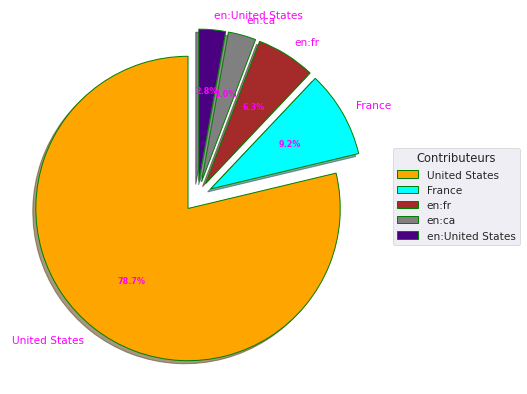

In [152]:
top_n('countries','pays',5)

<p>On retrouve principalement les Etats Unis, puis la France.</p>
<p>Dans l'idée de l'application de santé publique du ministère français il me semble approprié de ne pas conserver les données US qui présentent un biais trop important, d'autant que les produits US ne sont pas nécessairement disponibles en France.<p>

<b style="background-color:tomato;font-size:12px;">7.3 Quelles marques sont représentées</b>
<a id="brands"></a> 

Le top 10 des marques cumule 5.68 % du périmètre : 



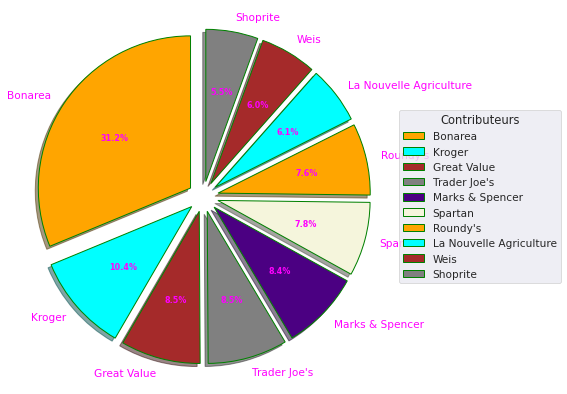

In [153]:
top_n('brands','marques',10)

Top 10 des marques en France

Text(0.5, 1.0, 'top 10 des marques en France')

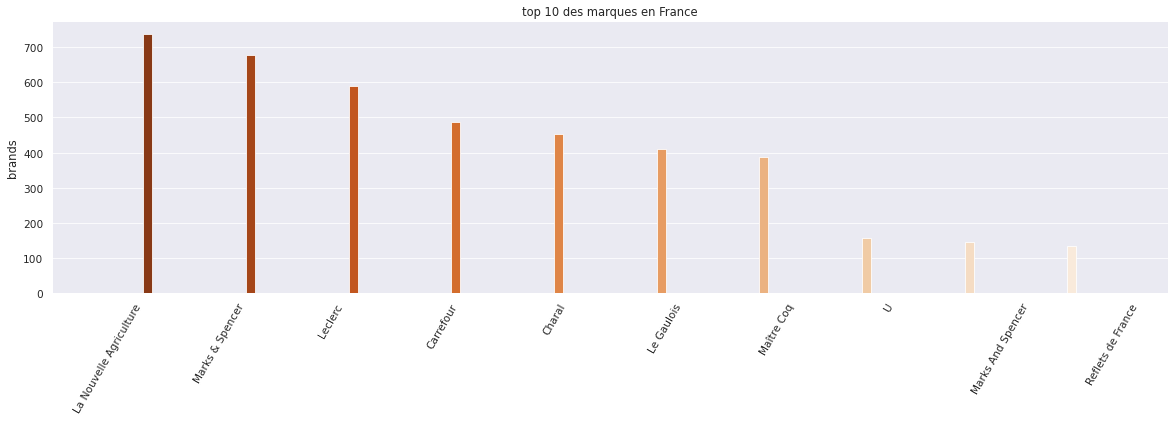

In [154]:
france = data[(data['countries']=="France") | (data['countries']=="en:FR") | (data['countries']=="en:france")]
y=france['brands'].value_counts().head(10)
x=france['brands'].value_counts().head(10).index
plt.figure(figsize=(20,5))
show = sns.barplot(x=x, y=y,hue=y, palette=("Oranges"))
rotate_labels(show)
show.legend_.remove()
plt.title("top 10 des marques en France")

<b style="background-color:tomato;font-size:12px;">7.4 Quels supermachés sont représentés</b>
<a id="stores"></a> 

Le top 10 des Supermarchés tous pays confondus cumule 2.79 % du périmètre : 



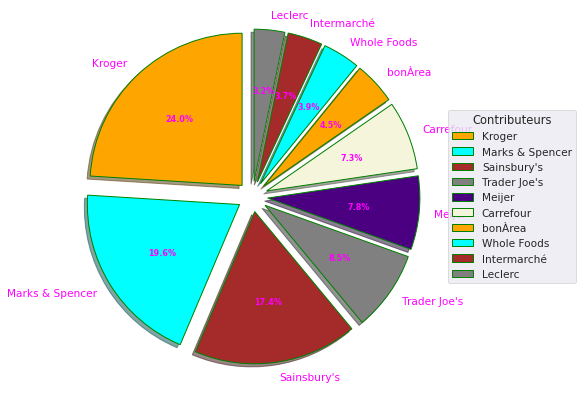

In [155]:
top_n('stores','Supermarchés tous pays confondus',10)

Top 10 des supermarchés en France

Text(0.5, 1.0, 'top 10 des supermarchés en France')

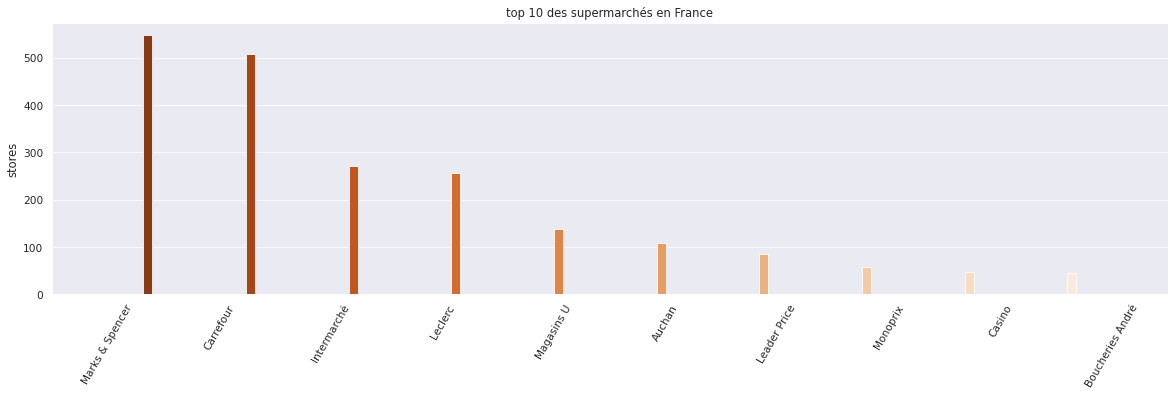

In [158]:
france = data[(data['countries']=="France") | (data['countries']=="en:FR") | (data['countries']=="en:france")]
us = data[(data['countries']=="United States") | (data['countries']=="en:US") | (data['countries']=="en:us")]

y=france['stores'].value_counts().head(10)
x=france['stores'].value_counts().head(10).index
plt.figure(figsize=(20,5))
show = sns.barplot(x=x, y=y,hue=y, palette=("Oranges"))
rotate_labels(show)
show.legend_.remove()
plt.title("top 10 des supermarchés en France")

<b style="background-color:tomato;font-size:12px;">7.5 Quelles catégories sont représentées</b>
<a id="categories"></a> 

                       Quelles sont les catégories les plus représentées ?


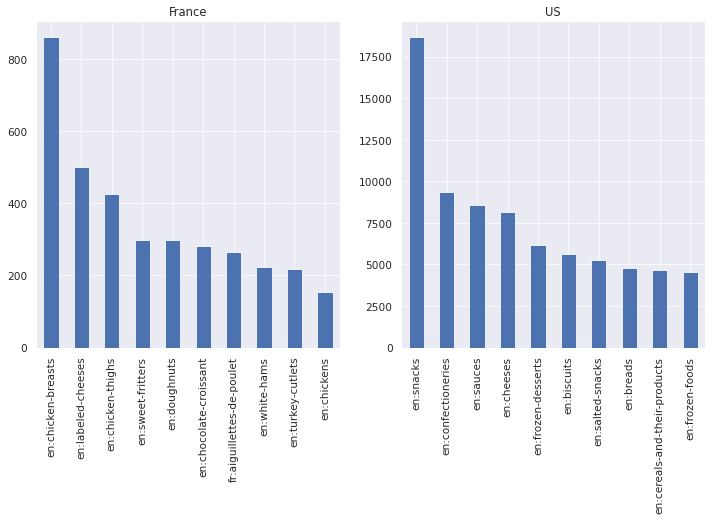

In [159]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fr_values = france['main_category'].value_counts()
us_values = us['main_category'].value_counts()
fr_values[0:10].plot(kind='bar', ax=ax1, title="France")
us_values[0:10].plot(kind='bar', ax=ax2, title="US")
print('                       Quelles sont les catégories les plus représentées ?')
plt.show()

In [160]:
def rotate_labels(axes):
    for item in axes.get_xticklabels():
        item.set_rotation(60)

In [161]:
def univariateBarPlotting(var, title):
    plt.figure(figsize=(20,5))
    fig = sns.barplot(y=data[var].index.values, x=data[var].values, color="blue")
    rotate_labels(fig)
    plt.title(title)

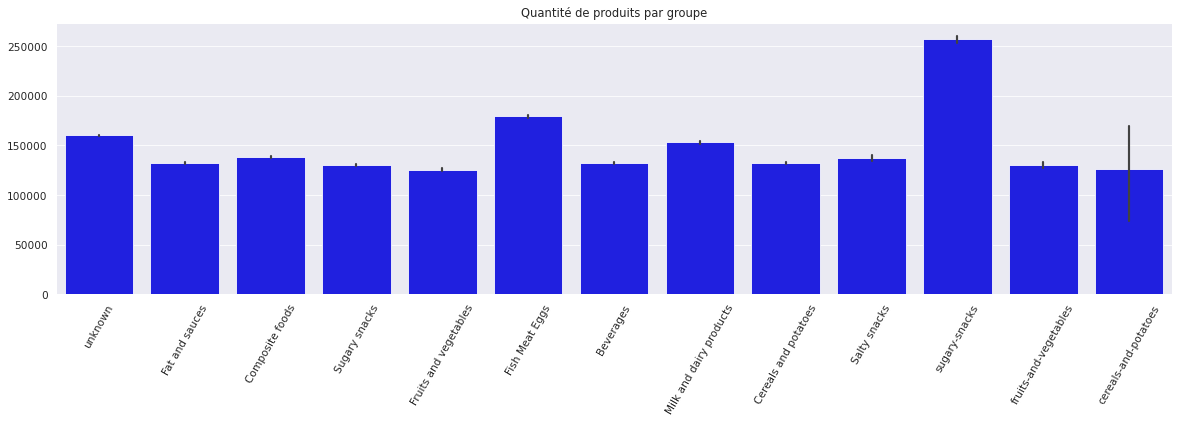

In [162]:
univariateBarPlotting('pnns_groups_1','Quantité de produits par groupe')

In [163]:
data['pnns_groups_1'].describe()

count      299400
unique         13
top       unknown
freq       136806
Name: pnns_groups_1, dtype: object

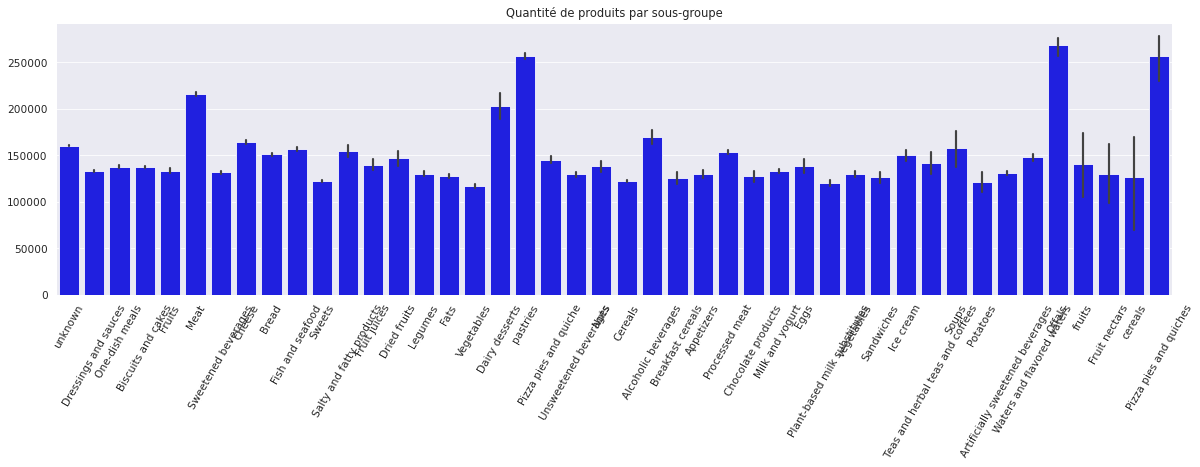

In [164]:
univariateBarPlotting('pnns_groups_2','Quantité de produits par sous-groupe')

In [165]:
def showSubCategContents(v):
    
    subset=data[(data['pnns_groups_2']==v)]
    ar=subset.values
    ar=ar[:30,7]

    fig = plt.figure()
    fig.suptitle('Zoom sur les 30 premiers aliments de la sous groupe ' + v, fontsize=12, fontweight='bold')

    ax = fig.add_subplot(111)

    i=0
    k=0
    for wd in enumerate(ar):
        if i%2 == 0:
            ax.text(1, (i+1), wd[1], color='green', fontsize=8)
        else:     
            ax.text(3, (i+1), wd[1], color='blue', fontsize=8)
        i = i + 1
    ax.axis([3, 0, 30, 0])   
    plt.axis('off')
    plt.show()

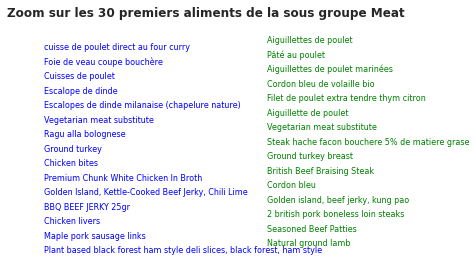

In [166]:
showSubCategContents("Meat")

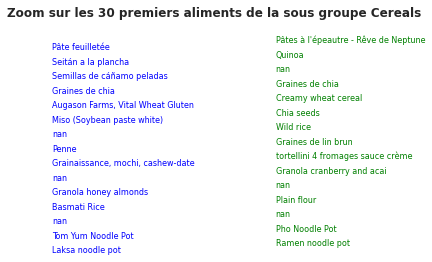

In [167]:
showSubCategContents("Cereals")

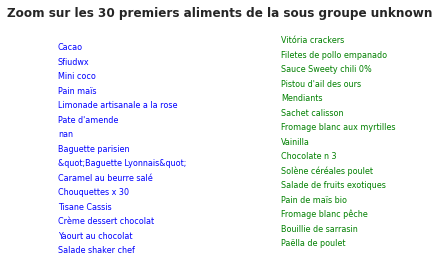

In [168]:
showSubCategContents("unknown")

<b style="background-color:tomato;font-size:12px;">7.6 Conclusion</b>
<a id="conclusion"></a> 

On constate qu'à première vue le dataset comporte de nombreux produits issus de la grande distribution. 
Sans préjuger de leur qualité nutritionnelle, il semble intéressant dans la cadre de la conception d'une application en lien avec la nutrition de mettre en perspective la qualité nutritionnelle de ces produits avec des produits bruts.
D'autre part dans les groupes (pnns_groups_1) et sous groupe (pnns_groups_2) les entrées correspondant à "unknown", qui représentent (/!\ donner des chiffres) ne présentent pas d'intérêt à être conservées, elles seront purgées dans la phase de clean. 

<b style="background-color:tomato;font-size:14px;">8. ANALYSE QUALITATIVE</b>
<a id="quality"></a> 

<b style="background-color:tomato;font-size:12px;">8.1 Identification des outliers<b>
    <a id="outliers"></a> 

On vérifie la présence d'outliers dans les différentes features porteuses d'information nutritionnelle. L'idée est d'évaluer la cohérence portée par celles-ci et d'avoir une idée du travail d'ajustement nécessaire.
Pour établir une règle générale on procède sur une sélection de ces features. On défira alors le seuil le plus approprié. 

In [169]:
quantite = ['energy_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'vitamin-pp_100g',
            'vitamin-b6_100g','vitamin-b9_100g','pantothenic-acid_100g', 'biotin_100g',
            'salt_100g','fat_100g','fiber_100g','sugars_100g']

In [170]:
sigma = [0 for _ in range(len(quantite))]
mediane = [0 for _ in range(len(quantite))]
for i in range(len(quantite)):
    colonne = quantite[i]
    mediane[i] = data[pd.notnull(data[colonne])][colonne].median()
    test = data[pd.notnull(data[colonne])][colonne]
    test = test.sort_values()    
    sigma[i] = np.std(test[:-25])    

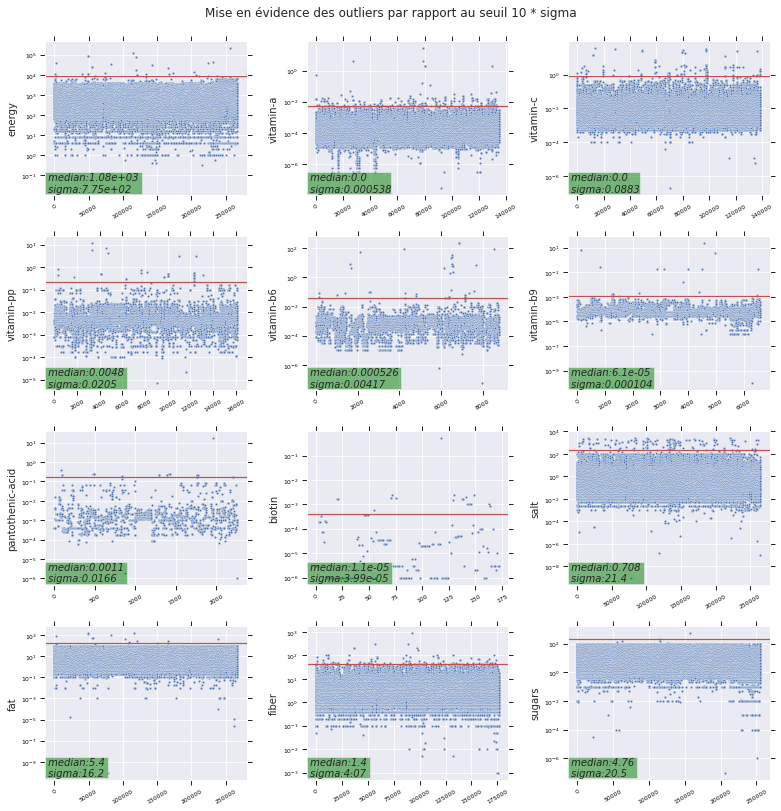

In [171]:
tPlot, axes = plt.subplots(nrows=4, ncols=3, sharex=False, sharey=False, figsize=(11,11))
axes = np.array(axes)
sigma_factor = 10
i=0
for ax in axes.reshape(-1):
    colonne = quantite[i]
    test = data[pd.notnull(data[colonne])][colonne]
    ax.tick_params(labelcolor='black',top='off',bottom='on',left='on',right='off',labelsize=6)
    ax.set_ylabel(colonne.rstrip("_100g"), fontsize = 10)
    ax.set_yscale("log")
    ax.plot(list(test), 'b.', markeredgewidth = 0.3, markeredgecolor='w')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    ax.axhline(y=mediane[i] + sigma_factor*sigma[i], color='r', linestyle='-')
    
    ax.text(0., 0.02, ' median:{:.3} \n sigma:{:.3}'.format(mediane[i], sigma[i]),
            style='italic', transform=ax.transAxes, fontsize = 10,
            bbox={'facecolor':'green', 'alpha':0.5, 'pad':0})
    i += 1

tPlot.text(0.5, 1.01, "Mise en évidence des outliers par rapport au seuil " + str(sigma_factor) + " * sigma", ha='center', fontsize = 12)
plt.tight_layout()

Après plusieurs ajustements du facteur de déviation standard des valeurs de feature par rapport à la médiane on arrive à un bon compromis avec 10 sigma. 
On pourra donc communiquer sur cette valeur auprès du reponsable du dataset, qui pourra procéder à l'abitrage (ajustement nécessaire, mise à l'écart du record complet). Il devra notamment tenir compte de la composition du produit et s'assurer que la valeur apparemment en outling ne soit pas portée par un seul ingrédent (comme par exemple le sel).  

<b style="background-color:tomato;font-size:12px;">8.2 Définition des données à compléter<b>
    <a id="complete"></a> 

Dans l'optique d'une application de santé publique on s'appuyera nécessairement sur les qualités intrinsèques du produit. Ces qualités sont portées par les features quantitatives. On propose donc de partir du périmètre des features quantitatives dont on va analyser la densité de contenu. Pour celles dont la densité est comprise dans la fourchette de 75% à 100% on proposera de les valoriser par une méthode de régression (point développé dans le notebook de clean).  

In [172]:
to_be_completed = percent_of_nans[(percent_of_nans < 25) & (percent_of_nans > 0)]
to_be_completed_high_density = to_be_completed.filter(like='_100g')
to_be_completed_high_density

saturated-fat_100g    20.186000
sugars_100g           14.838333
sodium_100g           11.732333
salt_100g             11.732333
energy-kcal_100g      11.239000
proteins_100g         11.009667
carbohydrates_100g    10.977667
fat_100g              10.960667
energy_100g           10.866333
dtype: float64

Pour celles dont la densité est comprise dans la fourchette de 50% à 75% on proposera de les valoriser par application de la valeur médiane.

In [173]:
to_be_completed = percent_of_nans[(percent_of_nans < 50) & (percent_of_nans >= 25 )]
to_be_completed_average_density = to_be_completed.filter(like='_100g')
to_be_completed_average_density

calcium_100g               43.698000
iron_100g                  43.519333
trans-fat_100g             42.419667
cholesterol_100g           42.141333
nutrition-score-fr_100g    42.078000
fiber_100g                 41.179333
dtype: float64

<b style="background-color:tomato;font-size:12px;">8.3 Identification des doublons<b>
    <a id="duplicates"></a> 

In [174]:
duplicates = []
for i,dup in enumerate(data.duplicated(subset=(['product_name','creator']))):
    if dup: 
        s = data["product_name"][i]
        if not pd.isna(s):
            r = [s,data["creator"][i]]
            duplicates.append(r)
len(duplicates)            

82463

In [175]:
duplicates[0:10]

[['Baguette Poitevin', 'kiliweb'],
 ['Baguette Niçois', 'kiliweb'],
 ['Compote de poire', 'kiliweb'],
 ['Peanuts', 'usda-ndb-import'],
 ['Vitória crackers', 'kiliweb'],
 ['Miel', 'kiliweb'],
 ['Colorant alimentaire', 'kiliweb'],
 ['Glaçage fondant', 'kiliweb'],
 ["Pate d'amandes", 'kiliweb'],
 ['Colorant alimentaire', 'kiliweb']]

In [176]:
sub = data.loc[(data['product_name'] == "Miel") & (data['creator'] == "kiliweb")]
sub

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
312,000000015710,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1579799939,2020-01-23T17:18:59Z,1607510430,2020-12-09T10:40:30Z,Miel,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
393,0000006638108,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1538567933,2018-10-03T11:58:53Z,1538567952,2018-10-03T11:59:12Z,Miel,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
907,0000485,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1578399617,2020-01-07T12:20:17Z,1607440861,2020-12-08T15:21:01Z,Miel,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,0007700026200,http://world-en.openfoodfacts.org/product/0007...,kiliweb,1575800220,2019-12-08T10:17:00Z,1575809423,2019-12-08T12:50:23Z,Miel,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20326,0014051000001,http://world-en.openfoodfacts.org/product/0014...,kiliweb,1540196337,2018-10-22T08:18:57Z,1552297049,2019-03-11T09:37:29Z,Miel,NaN,500 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141506,0055562112302,http://world-en.openfoodfacts.org/product/0055...,kiliweb,1602345215,2020-10-10T15:53:35Z,1602345217,2020-10-10T15:53:37Z,Miel,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142425,0055828375045,http://world-en.openfoodfacts.org/product/0055...,kiliweb,1604798487,2020-11-08T01:21:27Z,1604798493,2020-11-08T01:21:33Z,Miel,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143899,0057449003161,http://world-en.openfoodfacts.org/product/0057...,kiliweb,1550099302,2019-02-13T23:08:22Z,1550099304,2019-02-13T23:08:24Z,Miel,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145444,0058500000211,http://world-en.openfoodfacts.org/product/0058...,kiliweb,1593958334,2020-07-05T14:12:14Z,1593958335,2020-07-05T14:12:15Z,Miel,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154557,0063829150080,http://world-en.openfoodfacts.org/product/0063...,kiliweb,1553947512,2019-03-30T12:05:12Z,1580281068,2020-01-29T06:57:48Z,Miel,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sur cet exemple on comprend que pour un produit donné et un contributeur donné il n'y a pas de critère évident qui permettrait d'affiner la sélection pour ne retenir que le plus pertinent.
Allons plus loin, montrons que ces records ne sont pas des doublons. On considère ici uniquement les données du produit, à l'exclusion de son id servant à son référencement.

In [177]:
sub_rows=[]
for index, row in sub.iterrows():
    concat=""
    i=0
    for col in enumerate(row): 
        #print(col[1])
        if i > 0:
            concat+=str(col[1])
        i=1
    sub_rows.append(concat)

sub_rows

print('Doublons détectés pour product_name = "Miel" & creator = "kiliweb"')
print([item for item, count in collections.Counter(sub_rows).items() if count > 1])


Doublons détectés pour product_name = "Miel" & creator = "kiliweb"
[]


<p>On constate qu'il n'y a pas de doublons sur la sélection effectuée qui pourtant était candidate. 
<p>Il serait difficile de mettre au point une méthode de détection de doublon pour un résultat probablement marginal. A valider avec l'équipe projet dans ce cas. 
<p>Dans le cadre de notre mission, nous ne projetons donc pas de traiter les doublons.

<b style="background-color:tomato;font-size:14px;">9. DEFINITION DES FEATURES DE SCORING<b>
    <a id="def_features"></a> 

Nous pouvons établir les features entrant dans la composition du score nutritionnel en détectant les correlations fortes, qu'elles soient positives pour les features agissant négativement sur le nutriscore (quand la feature augmente, le nutriscore augmente ce qui indique un facteur de dégradation) ou négatives pour les features agissant positivement sur le nutriscore (quand la feature augmente, le nutriscore baisse ce qui indique un facteur d'amélioration)

In [115]:
def plotCorrelationMatrix(feature,title,corrmat):
    sns.set(context="paper", font_scale = 1.2)
    f, ax = plt.subplots(figsize=(11, 11))
    cols = corrmat.nlargest(25, feature)[feature].index
    cm = corrmat.loc[cols, cols] 
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                     fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'coolwarm',
                     yticklabels=cols.values, xticklabels=cols.values)
    f.text(0.5, 0.93, title, ha='center', fontsize = 18)
    plt.show()

In [118]:
cols = [c for c in data.columns if ((('_100g' in c.lower() and c.lower() != "nutrition-score-fr_100g" and c.lower() != "nutrition-score-uk_100g") 
                                     and not re.match('^-',c.lower())) 
                                    or c.lower() == 'nutriscore_score')]
sub_data=data[cols]
corrmat = sub_data.corr(method ='pearson')

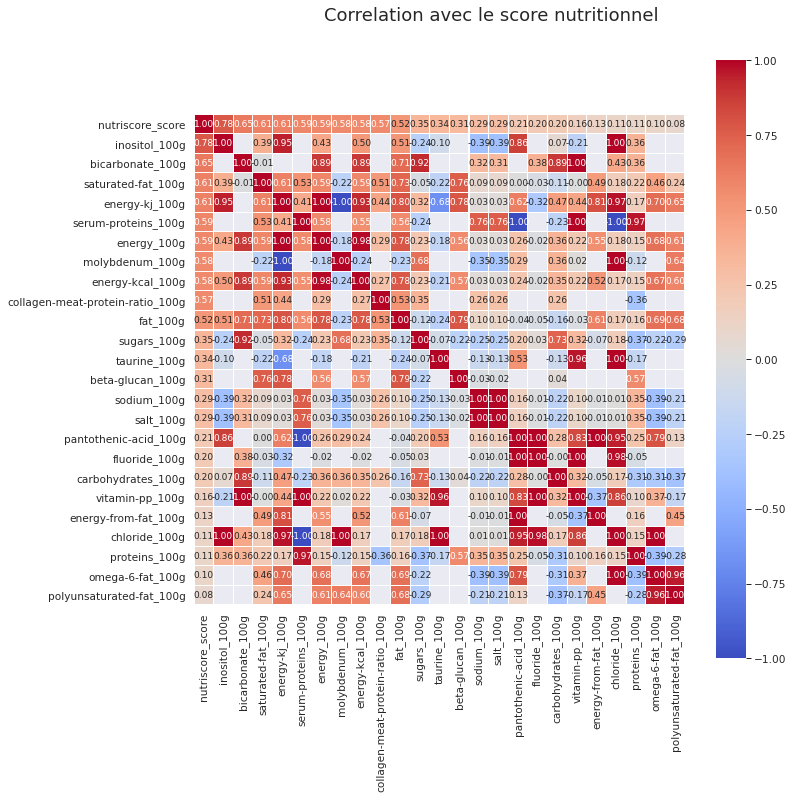

In [119]:
plotCorrelationMatrix('nutriscore_score','Correlation avec le score nutritionnel',corrmat)

<p>La matrice nous montre certaines des features qui ont un impact annoncé par la définition du nutriscore : </p>
<p>
<table>
    <tr>
       <td align="center" bgcolor="blue">Feature</td>
        <td align="center" bgcolor="blue">Coefficient de correlation</td>
        <td align="center" bgcolor="blue">Feature fortement corrélée</td>        
        <td align="center" bgcolor="blue">Paramètre de feature scoring associé</td>
    </tr>    
    <tr>
        <td>saturated-fat_100g</td>
        <td>0.59</td>
        <td>-</td>
        <td>Graisses saturées</td>
    </tr>
    <tr>
        <td>energy-kj_100g</td>
        <td>0.61</td>
        <td>energy-kcal_100g (r=0.93)</td>
        <td>Apport calorique</td>
    </tr>
    <tr>
        <td>serum-proteins_100g</td>
        <td>0.59</td>
        <td>proteins_100g (r=0.97)</td>
        <td>Protéines</td>
    </tr>    
    <tr>
        <td>sugars_100g</td>
        <td>0.35</td>
        <td>-</td>
        <td>Sucre</td>
    </tr>
</table>    
</p>    
<p>On note toutefois que ces features ont un coefficient de correlation modéré avec le nutriscore. </p>
<p>Il reste à identifier les 3 autres features </p>   
<p>A défaut de piste pour déterminer à partir d'une mise en évidence par correlation nous donnons les features que nous pouvons déterminer d'après leur nom, ce qui pourra se vérifier par la suite dans une analyse plus poussé par ACP :</p>
<table>
    <tr>
       <td align="center" bgcolor="blue">Feature</td>
        <td align="center" bgcolor="blue">Coefficient de correlation</td>
        <td align="center" bgcolor="blue">Feature fortement corrélée</td>        
        <td align="center" bgcolor="blue">Paramètre de feature scoring associé</td>
    </tr>    
    <tr>
        <td>fiber_100g</td>
        <td>n/a</td>
        <td>-</td>
        <td>Fibres</td>
    </tr>
    <tr>
        <td>salt_100g</td>
        <td>n/a</td>
        <td>-</td>
        <td>Fibres</td>
    </tr>
    <tr>
        <td>fruits-vegetables-nuts_100g</td>
        <td>n/a</td>
        <td>-</td>
        <td>Fruits, légumes, légumineuses, fruits à coque et huiles de colza, de noix et d’olive</td>
    </tr>
</table>

In [ ]:
del data
del percent_of_nans
del unusual_df
del to_be_completed
del to_be_completed_high_density
del to_be_completed_average_density

<b style="background-color:tomato;font-size:14px;">10. PROPOSITION D'APPLICATION<b>
    <a id="application"></a> 

<p><b>Exposition de la problématique</b><p>
Nous avons affaire à un dataset très gros par le nombre de features (183) et le nombre de lignes (~ 1 555 000), mais dont la densité d'imputation est "aérée". D'autre part les catégories de produit ne correspondent pas nécessairement à une classification "utilisateur" dans ce sens qu'elles répondent plus à un besoin de classification du point du vue de l'industriel, alors que le particulier attendrait plutôt une classification par type d'utilisation ou d'ingrédient brut. Cela peut s'expliquer par le fait que tel qu'on l'a montré les acteurs qui entrent les données sont des marques. Il semble donc difficile à partir de là pour un particulier de puiser dedans pour trouver des pistes lui permettant d'appliquer les conseils du ministère. 

<p><b>Objectif de l'application</b><p>     
Pour permettre à un particulier d'exploiter les données en vue d'appliquer les directives du ministère notre application doit lui permettre d'accéder à des alternatives de produit qui devraient lui permettre d'améliorer le score nutritionnel global d'un repas. 

<p><b>Comment</b><p>    
Fonctionnellement, l'application consiste à permettre la saisie des informations relatives au repas évalué (apéritif, entrée, plat, fromage/laitage, dessert), sur la base des composants du repas (et donc de leur catégorie d'utilisation) l'application doit détecter les composants de faible score nutritionnel pour lesquels elle devrait indiquer des alternatives qui offriraient un meilleur score nutritionnel global. L'application peut mettre en vis-à-vis un graphique radar du repas et de celui corrigé par ces alternatives. L'idée de l'application est de mettre en valeur les alternatives pour que l'utilisateur apprenne et puisse au fur et à mesure faire évoluer ses habitudes. Ayant une base de connaissance, lors de ses futurs achats en vue de préparer un repas il pourra alors mieux se diriger vers ces alternatives.

<p><b>Moyen à mettre en oeuvre</b><p>
Il nous faut approfondir l'analyse du dataset pour déterminer les features sur lesquels s'appuyer pour définir les alternatives de produits qui vont dans le sens des recommandations du ministère. Pour cela nous effectuerons notamment une analyse de composantes principales, et tenterons également d'établir des correlations entre variables quantitatives et qualitatives pour dégager des pistes de suggestion d'alternatives sur des éléments qualitatifs. 